# ***PA - Part I: Basic Vision Models [Experiments with MNIST]*** (55pt)

**Keywords**: Multiclass Image Classification, Neural Networks, PyTorch

**MNIST**
* The [MNIST](https://en.wikipedia.org/wiki/MNIST_database) database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.
* The MNIST database contains 70,000 labeled images. Each datapoint is a $28\times 28$ pixels grayscale image.
* However to speed up computations, we will use a much smaller dataset with size $8\times 8$ images. These images are loaded from `sklearn.datasets`.

**Agenda**:
* The PA is split into three parts, the first part dealing with miniature models which we will build from scratch, the second part dealing with modern architectures and the bonus third part dealing with training vision models robust to adversarial attacks.
* In this part, we will be performing multiclass classification on the simplified MNIST dataset from scratch.
* We will be applying and analysing different loss functions, optimization techniques and learning methods.

* We will be using PyTorch to do most of the heavylifting for modeling and training.

**Note:**
* Hardware acceleration (GPU) is recommended but not required for this part.
* A note on working with GPU:
  * Take care that whenever declaring new tensors, set `device=device` in parameters.
  * You can also move a declared torch tensor/model to device using `.to(device)`.
  * To move a torch model/tensor to cpu, use `.to('cpu')`
  * Keep in mind that all the tensors/model involved in a computation have to be on the same device (CPU/GPU).
* Run all the cells in order.
* Only **add your code** to cells marked with "TODO:" or with "..."
* You should not have to change variable names where provided, but you are free to if required for your implementation.



---



### ***Setup: Imports and Utils***

In [86]:
# imports
import torch
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# loading the dataset directly from the scikit-learn library
dataset = load_digits()
X = dataset.data
y = dataset.target
print('Number of images:', X.shape[0])
print('Number of features per image:', X.shape[1])

Number of images: 1797
Number of features per image: 64


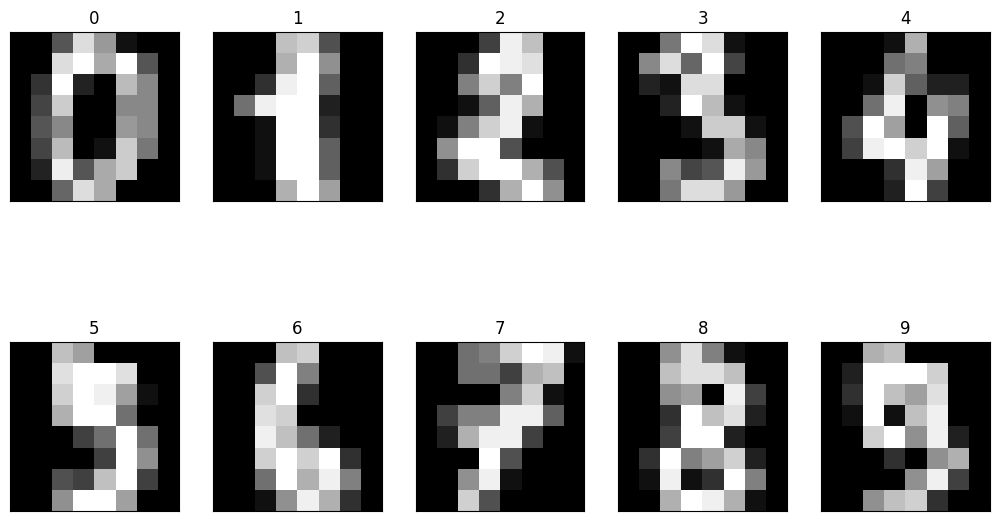

In [87]:
# utility function to plot gallery of images
def plot_gallery(images, titles, height, width, n_row=2, n_col=4):
    plt.figure(figsize=(2* n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# visualize some of the images of the MNIST dataset
plot_gallery(X, y, 8, 8, 2, 5)

In [88]:
# Let us split the dataset into training and test sets in a stratified manner.
# Note that we are not creating evaluation datset as we will not be tuning hyper-parameters
# The split ratio is 4:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Shape of train dataset:', X_train.shape)
print('Shape of evaluation dataset:', X_test.shape)

Shape of train dataset: (1437, 64)
Shape of evaluation dataset: (360, 64)


In [89]:
# define some constants - useful for later
num_classes = len(np.unique(y)) # number of target classes = 10 -- (0,1,2,3,4,5,6,7,8,9)
num_features = X.shape[1]       # number of features = 64
max_epochs = 100000             # max number of epochs for training
lr = 1e-2                       # learning rate
tolerance = 1e-6                # tolerance for early stopping during training

In [90]:
# Hardware Acceleration: to set device if using GPU.
# You can change runtime in colab by naviagting to (Runtime->Change runtime type), and selecting GPU in hardware accelarator.
# NOTE that you can run this homework without GPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'



---



### *(a) Utils and pre-processing* (5pt)

* Scale the image data between 0 and 1
* One-hot encode the target data
* Convert the data to tensors and move them to the required device

In [91]:
# 1. Scale the features between 0 and 1
# To scale, you can directly use the MinMaxScaler from sklearn.
#######
#TODO:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# output variable names -  X_train, X_test
#######
print(X_train)
print(X_test)

[[0.     0.     0.6875 ... 0.125  0.     0.    ]
 [0.     0.     0.125  ... 0.0625 0.     0.    ]
 [0.     0.125  0.9375 ... 0.     0.     0.    ]
 ...
 [0.     0.     0.0625 ... 0.1875 0.     0.    ]
 [0.     0.     0.25   ... 0.     0.     0.    ]
 [0.     0.     0.1875 ... 1.     1.     0.1875]]
[[0.         0.         0.5        ... 0.25       0.         0.        ]
 [0.         0.42857143 1.         ... 0.5        0.1875     0.        ]
 [0.         0.         0.125      ... 0.0625     0.         0.        ]
 ...
 [0.         0.         0.625      ... 0.1875     0.         0.        ]
 [0.         0.         0.4375     ... 0.75       0.         0.        ]
 [0.         0.         0.         ... 0.125      0.         0.        ]]


In [92]:
# 2. One-Hot encode the target labels
# To one-hot encode, you can use the OneHotEncoder from sklearn
#######
#TODO:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False) # To make the ohe not sparse (to avoid the ambiguous length of the sparse array when converting them to torch)
y_train_ohe = ohe.fit_transform(y_train.reshape(-1,1)) # Reshape: ohe need a 2d-array input
y_test_ohe = ohe.fit_transform(y_test.reshape(-1,1))

# output variable names -  y_train_ohe, y_test_ohe
#######
print('Shape of y_train_ohe:',y_train_ohe.shape)
print('Shape of y_test_ohe:',y_test_ohe.shape)


# move X and y to the defined device and convert them to torch.float32
X_train_torch = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_ohe_torch = torch.tensor(y_train_ohe, dtype=torch.float32, device=device)
y_test_ohe_torch = torch.tensor(y_test_ohe, dtype=torch.float32, device=device)

# output variable names -  X_train_torch, X_test_torch, y_train_ohe_torch, y_test_ohe_torch
print(X_train_torch)
print(X_test_torch)
print(y_train_ohe_torch)
print(y_test_ohe_torch)

Shape of y_train_ohe: (1437, 10)
Shape of y_test_ohe: (360, 10)
tensor([[0.0000, 0.0000, 0.6875,  ..., 0.1250, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1250,  ..., 0.0625, 0.0000, 0.0000],
        [0.0000, 0.1250, 0.9375,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0625,  ..., 0.1875, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2500,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1875,  ..., 1.0000, 1.0000, 0.1875]],
       device='cuda:0')
tensor([[0.0000, 0.0000, 0.5000,  ..., 0.2500, 0.0000, 0.0000],
        [0.0000, 0.4286, 1.0000,  ..., 0.5000, 0.1875, 0.0000],
        [0.0000, 0.0000, 0.1250,  ..., 0.0625, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.6250,  ..., 0.1875, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4375,  ..., 0.7500, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1250, 0.0000, 0.0000]],
       device='cuda:0')
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0.,

### *(b) Implement Multi-Class Logistic Regression from scratch* (15pt)

In this problem, we will apply multiclass logistic regression from scratch  trained using gradient descent (GD) with Mean Squared Error (MSE) loss as the objective.

We will be using a linear model $y^{(i)} = W \mathbf{x}^{(i)}$, with the following notations:

* Weight matrix:
$ W_{p\times n}= \begin{bmatrix}
\leftarrow & \mathbf{w}_1^\top & \rightarrow \\
\leftarrow & \mathbf{w}_2^\top & \rightarrow\\
 & \vdots &  \\
\leftarrow & \mathbf{w}_p^\top & \rightarrow \\
\end{bmatrix}$, where $p$ is the number of target classes

* data points: $\mathbf{x}^{(i)}\in \mathbb{R}^n, y^{(i)}\in \mathbb{R}$, and $X = \begin{bmatrix}
\uparrow &  \uparrow & \dotsm &  \uparrow\\
\mathbf{x}^{(1)} & \mathbf{x}^{(2)} & \dotsm & \mathbf{x}^{(m)} \\
\downarrow & \downarrow  & \dotsm & \downarrow  \\
\end{bmatrix}, Y = \begin{bmatrix}
y^{(1)}\\
y^{(2)} \\
\vdots \\
y^{(m)} \\
\end{bmatrix}$, where $m$ is the number of datapoints.

**Note:** Here we need to define the model prediction. The input matrix is $X_{n\times m}$ where $m$ is the number of examples, and $n$ is the number of features. The linear predictions can be given by: $Y = WX + b$ where $W$ is a $p\times n$ weight matrix and $b$ is a $p$ size bias vector. $p$ is the number of target classes.

#### #1. Define a function `linear_model`

* This function takes as input a weight matrix (`W`), bias vector (`b`), and input data matrix of size $m\times n$ (`XT`).
* This function should return the predictions $\hat{y}$, which is an $m\times p$ matrix. For each datapoint row which is a $1 \times p$ vector, the prediction can be seen as the scores that the model gives each target class for that datapoint

In [93]:
#######
def linear_model(W, b, XT):
    #TODO:
    y_hat = XT @ W.T + b
    return y_hat

#######

**Note:** The loss function that we would be using is the Mean Square Error (L2) Loss:\
$\displaystyle MSE = \frac{1}{m}\sum_{i=1}^m(\hat{y}^{(i)}-y^{(i)})^2$, where $m$ is the number of examples, $\hat{y}^{(i)}$ is the
predicted value of $x^{(i)}$ and $y^{(i)}$ is the ground truth of $x^{(i)}$.

#### #2. Define a function `mse_loss`

* This function takes as input prediction (`y_pred`) and ground-truth label (`y`), and returns the MSE loss.

In [94]:
#######
def mse_loss(y_pred, y):
    #TODO:
    loss = torch.mean((y_pred - y) ** 2)
    return loss

#######


#### #3. Define a function: `initializeWeightsAndBiases`

In this part, we will do some setup required for training (such as initializing weights and biases) and move everything to torch tensors.


* This function returns tuple `(W, b)`, where `W` is a randomly generated torch tensor of size `num_classes x num_features`, and `b` is a randomly generated torch vector of size `num_classes`.
* For both the tensors, set `requires_grad=True` in parameters.



In [95]:
#######
def initializeWeightsAndBiases(num_classes, num_features):
    #TODO:
    W = torch.randn(num_classes, num_features, device=device, requires_grad=True) # requires_grad: allow Gradient Updates
    b = torch.randn(num_classes, device=device, requires_grad=True)
    return W, b
#######

#### #4 Training code

* Given below is a function: `train_linear_regression_model` that takes as inputs as max number of epochs (`max_epochs`), weights (`W`), biases (`b`), training data (`X_train, y_train`), learning rate (`lr`), tolerance for stopping (`tolerance`).
* This function returns a tuple `(W,b,losses)` where `W,b` are the trained weights and biases respectively, and `losses` is a list of tuples of loss logged every $100^{th}$  epoch.
* You can go through [this](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-tensors-and-autograd) article for reference.

In [96]:
# Define a function train_linear_regression_model
def train_linear_regression_model(max_epochs, W, b, X_train, y_train, lr, tolerance):
  #TODO:
  losses = []
  prev_loss = float('inf')

  for epoch in tqdm(range(max_epochs)):

      #######
      # 7. do prediction
      y_pred = linear_model(W, b, X_train)

      # 8. get the loss
      loss = mse_loss(y_pred, y_train)

      # 9. backpropagate loss
      loss.backward()

      # 10. update the weights and biasees
      with torch.no_grad():
        W -= lr * W.grad
        b -= lr * b.grad

      # 11. set the gradients to zero
      W.grad = None # Equivalent to W.grad.zero()
      b.grad = None

      #######

      # log the loss every 100th epoch and print every 5000th epoch:
      if epoch%100==0:
        losses.append((epoch, loss.item())) # loss.item(): tensor -> float num
        if epoch%5000==0:
          print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))

      # break if decrease in loss is less than threshold
      if abs(prev_loss - loss.item()) < tolerance:
        print(f"Break! Early stopping at epoch {epoch} due to low improvement in loss.")
        break
      prev_loss = loss.item()

  # return updated weights, biases, and logged losses
  return W, b, losses

#### #5. Initialize parameters and train your own model

* Initialize weights and biases using the `initializeWeightsAndBiases` function that you defined earlier
* Train your model using function `train_linear_regression_model` defined above.
* Use full batch (set `batch_size=len(X_train)` for training (Gradient Descent).
* Also plot the graph of loss vs number of epochs (Recall that values for learning rate (`lr`) and tolerance (`tolerance`) are already defined above).

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 17.706771850585938
Epoch: 5000, Loss: 0.5214282870292664
Epoch: 10000, Loss: 0.2865198254585266
Epoch: 15000, Loss: 0.19979605078697205
Epoch: 20000, Loss: 0.15468721091747284
Epoch: 25000, Loss: 0.12691180408000946
Epoch: 30000, Loss: 0.1080709770321846
Epoch: 35000, Loss: 0.09449117630720139
Epoch: 40000, Loss: 0.08429207652807236
Epoch: 45000, Loss: 0.07640080899000168
Epoch: 50000, Loss: 0.07015533745288849
Break! Early stopping at epoch 52374 due to low improvement in loss.


Text(0.5, 1.0, 'loss vs epochs')

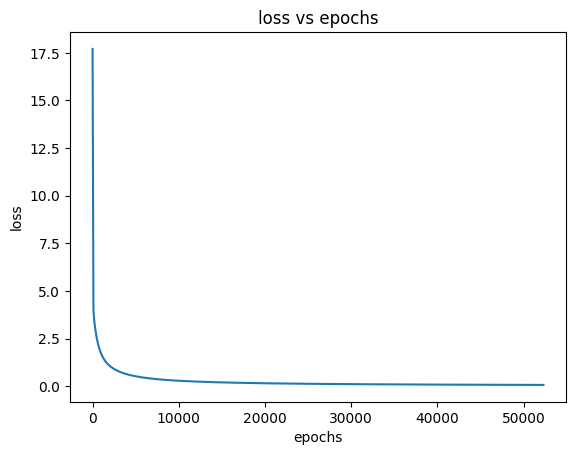

In [97]:
#######
#TODO:
W, b = initializeWeightsAndBiases(num_classes, num_features)

W, b, losses = train_linear_regression_model(
    max_epochs=max_epochs,
    W=W,
    b=b,
    X_train=X_train_torch,
    y_train=y_train_ohe_torch,
    lr=lr,
    tolerance=tolerance
)

import matplotlib.pyplot as plt
plt.plot([x[0] for x in losses],[x[1] for x in losses])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
#######

In [98]:
# print accuracies of model
predictions_train = linear_model(W, b, X_train_torch)
predictions_test = linear_model(W, b, X_test_torch)

# Get the predicted label with the maximum score in score matrix
y_train_pred = torch.argmax(predictions_train, dim=1).cpu().numpy() # accuracy_score() can only process np.ndarray
y_test_pred = torch.argmax(predictions_test, dim=1).cpu().numpy()

print("Train accuracy:",accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32)))
print("Test accuracy:",accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32)))

Train accuracy: 0.8413361169102297
Test accuracy: 0.7861111111111111


### *(c) Use PyTorch for training* (10pt)

* In the previous part, we defined the model, loss, and even the gradient update step. We also had to manually set the gradients to zero.
* In this part, we will re-implement the linear model and see how we can directly use Pytorch to do all this for us in a few simple steps.

In [99]:
# common utility function to print accuracies
def print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test):
  predictions_train = model(X_train_torch)
  predictions_test = model(X_test_torch)
  y_train_pred = torch.argmax(predictions_train, dim=1).cpu().numpy()
  y_test_pred = torch.argmax(predictions_test, dim=1).cpu().numpy()
  print("Train accuracy:",accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32)))
  print("Test accuracy:",accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32)))

#### #1. Define the linear model using PyTorch

* Use the inbuilt PyTorch `torch.nn.Module` to define a model class.
* Use the `torch.nn.Linear` to define the linear layer of the model

In [100]:
#######

# Define a model class using torch.nn
class Linear_Model(torch.nn.Module):
  def __init__(self):
    super(Linear_Model, self).__init__()
    # Initalize various layers of model as below
    # 1. initialze one linear layer: num_features -> num_targets
    self.linear = torch.nn.Linear(num_features, num_classes)

  def forward(self, X):
    # 2. define the feedforward algorithm of the model and return the final output
    output = self.linear(X)
    return output

#######

#### #2. A general function for training a PyTorch model.

Define a general training function: `train_torch_model`.
* This function takes as input an initialized torch model (`model`), batch size (`batch_size`), initialized loss (`criterion`), max number of epochs (`max_epochs`), training data (`X_train, y_train`), learning rate (`lr`), tolerance for stopping (`tolerance`).
* This function will return a tuple `(model, losses)`, where `model` is the trained model, and `losses` is a list of tuples of loss logged every $100^{th}$ epoch.

Note: You can reuse a lot of components from the `train_linear_regression_model` function from the previous section

You can go through [this](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-optim) article for reference.

In [101]:
# Define a function train_torch_model
def train_torch_model(model, batch_size, criterion, max_epochs, X_train, y_train, lr, tolerance):
  losses = []
  prev_loss = float('inf')
  number_of_batches = math.ceil(len(X_train)/batch_size)

  #######
  # 3. move model to device
  model.to(device)

  # 4. define optimizer (use torch.optim.SGD (Stochastic Gradient Descent))
  # Set learning rate to lr and also set model parameters
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  for epoch in tqdm(range(max_epochs)):
    for i in range(number_of_batches):
      start = i * batch_size
      end = start + batch_size
      X_train_batch = X_train[start:end]
      y_train_batch = y_train[start:end]

      # 5. reset gradients
      optimizer.zero_grad()

      # 6. prediction
      prediction = model(X_train_batch)

      # 7. calculate loss
      loss = criterion(prediction, y_train_batch)

      # 8. backpropagate loss
      loss.backward()

      # 9. perform a single gradient update step
      optimizer.step()

  #######

    # log loss every 100th epoch and print every 5000th epoch:
    if epoch%100==0:
      losses.append((epoch, loss.item()))
      if epoch%5000==0:
        print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))

    # break if decrease in loss is less than threshold
    if abs(prev_loss - loss.item()) < tolerance:
      print(f"Break! Early stopping at epoch {epoch}")
      break
    prev_loss = loss.item()

  # return updated model and logged losses
  return model, losses

### *(d) Working with different model types* (15pt)
* Now, we retrain the above model with `batch_size=64`
* Use Stochastic/Mini-batch Gradient Descent and keep everything else the same.
* Like before, we plot the graph between loss and number of epochs.

#### #1. MSE Loss and Gradient Descent (GD)
* Use `nn.MSELoss`.
* Use full batch for training (Gradient Descent).
* Also plot the graph of loss vs number of epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.14073053002357483
Epoch: 5000, Loss: 0.03942379355430603
Break! Early stopping at epoch 6200


Text(0.5, 1.0, 'loss vs epochs')

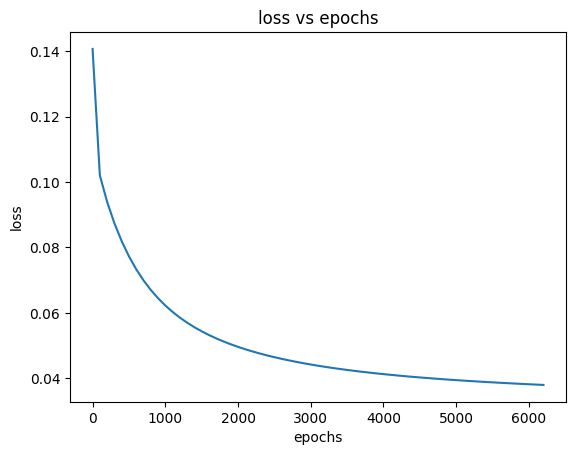

In [102]:
#######
model = Linear_Model()
criterion = torch.nn.MSELoss()
batch_size = X_train_torch.shape[0] # Full batch: GD

model, losses = train_torch_model(
    model=model,
    batch_size=batch_size,
    criterion=criterion,
    max_epochs=max_epochs,
    X_train=X_train_torch,
    y_train=y_train_ohe_torch,
    lr=lr,
    tolerance=tolerance
)

import matplotlib.pyplot as plt
plt.plot([x[0] for x in losses],[x[1] for x in losses])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
#######

In [103]:
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9290187891440501
Test accuracy: 0.9361111111111111


#### #2. MSE Loss and Stochastic Gradient Descent (SGD)
* Use `nn.MSELoss`.
* Use `batch_size=64` for training
* Also plot the graph of loss vs number of epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.13629525899887085
Break! Early stopping at epoch 1678


Text(0.5, 1.0, 'loss vs epochs')

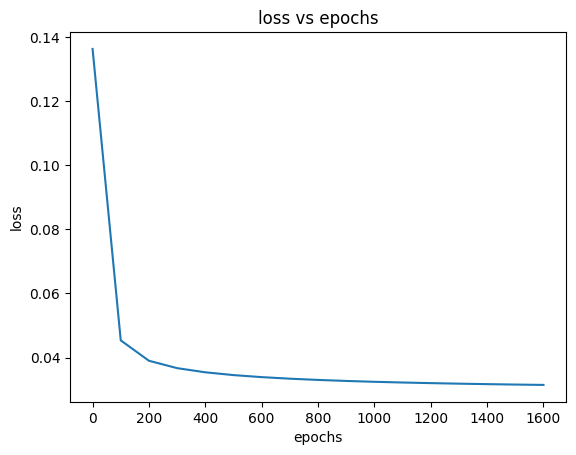

In [104]:
#######
model = Linear_Model()
criterion = torch.nn.MSELoss()
batch_size = 64 # Small BatchL: SGD
model, losses = train_torch_model(
    model=model,
    batch_size=batch_size,
    criterion=criterion,
    max_epochs=max_epochs,
    X_train=X_train_torch,
    y_train=y_train_ohe_torch,
    lr=lr,
    tolerance=tolerance
)

import matplotlib.pyplot as plt
plt.plot([x[0] for x in losses],[x[1] for x in losses])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
#######

In [105]:
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9450243562978428
Test accuracy: 0.95




---



#### **Cross-Entropy (CE) Loss with Linear Model**
* Instead of using MSE Loss, we will use a much more natural loss function for the multi-class logistic regression task which is the Cross Entropy Loss.
* CE loss converts the model scores of each class into a probability.
* This model penalizes both choosing the wrong class as well as uncertainty (choosing the right class with low probability).
* And we will use the same linear model defined in **(c)**.


**Note:**
The [Cross Entropy Loss](https://ebookreading.net/view/book/EB9781789130331_73.html) for multiclass classification is the mean of the negative log likelihood of the output logits after softmax:\
$L = \underbrace{\frac{1}{m} \sum_{i=1}^m \underbrace{-y^{(i)} \underbrace{log \underbrace{\frac{e^{\hat{y}^{(i)}}}{\sum_{j=1}^p e^{\hat{y}^{(j)}}}}_{\text{Softmax}}}_{\text{LogSoftmax}}}_{\text{Negative Log Likelihood (NLL)}}}_{\text{Cross Entropy (CE) Loss }}$,


where $y^{(i)}$ is the ground truth, and $\hat{y}^{(k)}$ (also called as *logits*) represent the outputs of the last linear layer of the model.

#### #3. CE Loss and GD
* Instead of `nn.MSELoss`, train the linear model with `nn.CrossEntropyLoss`.
* Use **full-batch**.
* Also plot the graph between loss and number of epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.3591091632843018
Epoch: 5000, Loss: 0.40864360332489014
Epoch: 10000, Loss: 0.27448174357414246
Epoch: 15000, Loss: 0.22115346789360046
Epoch: 20000, Loss: 0.1908445954322815
Epoch: 25000, Loss: 0.17064359784126282
Epoch: 30000, Loss: 0.15589269995689392
Epoch: 35000, Loss: 0.1444670855998993
Epoch: 40000, Loss: 0.13524574041366577
Epoch: 45000, Loss: 0.12757539749145508
Epoch: 50000, Loss: 0.1210467740893364
Epoch: 55000, Loss: 0.11538895219564438
Break! Early stopping at epoch 56144


Text(0.5, 1.0, 'loss vs epochs')

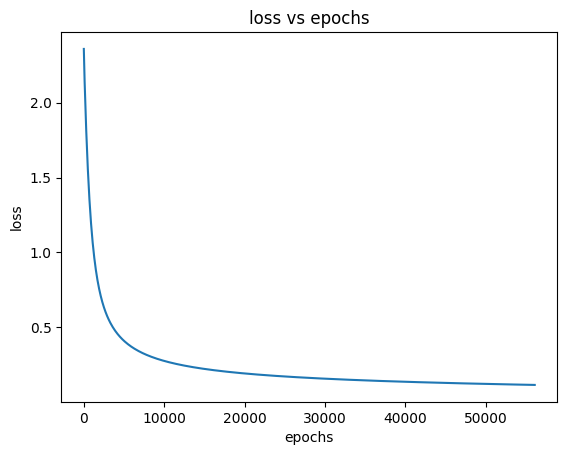

In [106]:
#######
model = Linear_Model()
criterion = torch.nn.CrossEntropyLoss()
batch_size = X_train_torch.shape[0]
model, losses = train_torch_model(
    model=model,
    batch_size=batch_size,
    criterion=criterion,
    max_epochs=max_epochs,
    X_train=X_train_torch,
    y_train=y_train_ohe_torch,
    lr=lr,
    tolerance=tolerance
)

import matplotlib.pyplot as plt
plt.plot([x[0] for x in losses],[x[1] for x in losses])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
#######

In [107]:
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9798190675017397
Test accuracy: 0.9638888888888889


#### #4. CE Loss and SGD
* Use a different batch size, `batch_size=64` with the new loss and repeat the previous part #1.
* Also plot the graph of loss vs epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.277090311050415
Epoch: 5000, Loss: 0.0869542807340622
Epoch: 10000, Loss: 0.061202846467494965
Epoch: 15000, Loss: 0.04852709919214249
Epoch: 20000, Loss: 0.04068692773580551
Break! Early stopping at epoch 23106


Text(0.5, 1.0, 'loss vs epochs')

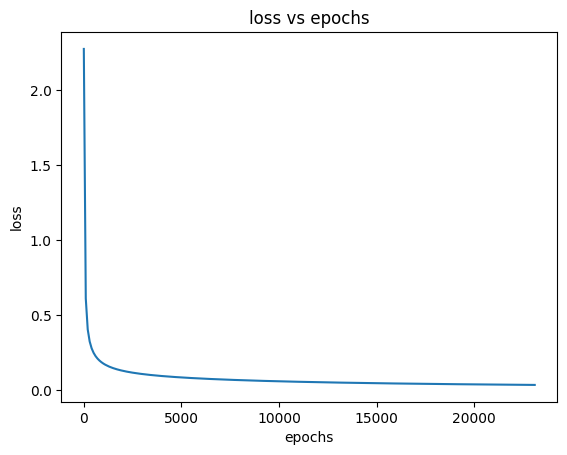

In [108]:
#######
model = Linear_Model()
criterion = torch.nn.CrossEntropyLoss()
batch_size = 64
model, losses = train_torch_model(
    model=model,
    batch_size=batch_size,
    criterion=criterion,
    max_epochs=max_epochs,
    X_train=X_train_torch,
    y_train=y_train_ohe_torch,
    lr=lr,
    tolerance=tolerance
)

import matplotlib.pyplot as plt
plt.plot([x[0] for x in losses],[x[1] for x in losses])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
#######

In [109]:
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9979123173277662
Test accuracy: 0.9694444444444444




---



#### **Training a neural network model in PyTorch**

* We will train a neural network in pytorch with two hidden layers of sizes 32 and 16 neurons.
* We will use non-linear ReLU activations to effectively make it a non-linear model.
* We will use this neural network model for multi-class classification with Cross Entropy Loss.

**Note:** The neural network model output can be represented mathematically as below:
$\hat{y}^{(i)}_{10\times1} = W^{(3)}_{10\times 16}\sigma(W^{(2)}_{16\times 32}\sigma(W^{(1)}_{32\times 64}\mathbf{x}^{(i)}_{64\times1}+\mathbf{b}^{(1)}_{32\times1})+\mathbf{b}^{(2)}_{16\times1})+\mathbf{b}^{(3)}_{10\times1}$,
where $\sigma$ represents ReLU activation, $W^{(i)}$ is the weight of the $i^{th}$ linear layer, and $\mathbf{b}^{(i)}$ is the layer's bias. We use the subscript to denote the dimension for clarity.

#### #5. Define the 2 hidden-layer Neural Network (NN)

In [110]:
#######
# Define a neural network model class using torch.nn
class NN_Model(torch.nn.Module):
  def __init__(self):
    super(NN_Model, self).__init__()
    # Initalize various layers of model as instructed below
    # 1. initialize three linear layers: num_features -> 32, 32 -> 16, 16 -> num_targets
    self.fc1 = torch.nn.Linear(num_features, 32)
    self.fc2 = torch.nn.Linear(32, 16)
    self.fc3 = torch.nn.Linear(16, num_classes)

    # 2. initialize RELU
    self.relu = torch.nn.ReLU()

  def forward(self, X):
    # 3. define the feedforward algorithm of the model and return the final output
    # Apply non-linear ReLU activation between subsequent layers
    x1 = self.relu(self.fc1(X)) # Layer 1 -> Layer 2
    x2 = self.relu(self.fc2(x1)) # Layer 2 -> Layer 3
    output = self.fc3(x2)
    return output

#######

print(X_train_torch.shape)
print(num_features)
print(num_classes)

torch.Size([1437, 64])
64
10


#### #6. NN with CE Loss and GD
* Use Cross Entropy Loss.
* Use full-batch and plot the graph of loss vs number of epochs.
* Note that you can re-use the training function `train_torch_model` (from part (b)).

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.3116660118103027
Epoch: 5000, Loss: 0.20603753626346588
Epoch: 10000, Loss: 0.09224589914083481
Epoch: 15000, Loss: 0.055876996368169785
Epoch: 20000, Loss: 0.03684386983513832
Epoch: 25000, Loss: 0.025357631966471672
Epoch: 30000, Loss: 0.01810634322464466
Break! Early stopping at epoch 31236


Text(0.5, 1.0, 'loss vs epochs')

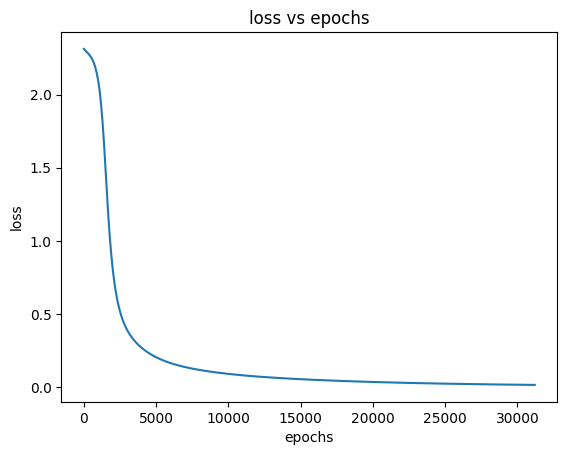

In [135]:
#######
model = NN_Model()
criterion = torch.nn.CrossEntropyLoss()
batch_size = X_train_torch.shape[0]
model, losses = train_torch_model(
    model=model,
    batch_size=batch_size,
    criterion=criterion,
    max_epochs=max_epochs,
    X_train=X_train_torch,
    y_train=y_train_ohe_torch,
    lr=lr,
    tolerance=tolerance
)

import matplotlib.pyplot as plt
plt.plot([x[0] for x in losses],[x[1] for x in losses])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
#######

In [136]:
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9993041057759221
Test accuracy: 0.9555555555555556


#### #7. NN with CE Loss and SGD
* Re-train the above model with `batch_size=64`.
* Also plot the graph of loss vs epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.35133957862854
Break! Early stopping at epoch 1312


Text(0.5, 1.0, 'loss vs epochs')

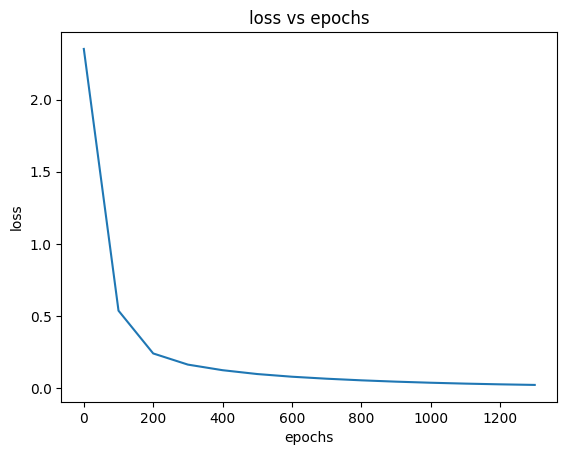

In [128]:
#######
model = NN_Model()
criterion = torch.nn.CrossEntropyLoss()
batch_size = 64
model, losses = train_torch_model(
    model=model,
    batch_size=batch_size,
    criterion=criterion,
    max_epochs=max_epochs,
    X_train=X_train_torch,
    y_train=y_train_ohe_torch,
    lr=lr,
    tolerance=tolerance
)

import matplotlib.pyplot as plt
plt.plot([x[0] for x in losses],[x[1] for x in losses])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
#######

In [129]:
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9993041057759221
Test accuracy: 0.9638888888888889




---



### *(e) Analyze the results* (10pt)

In the above few examples, we performed several experiments with different batch size and loss functions. Now it's time to analyze our observations from the results.

Recall that we trained the following models in this tutorial:

1.   Linear Model - Scratch + MSE Loss + Full Batch (GD)
2.   Linear Model - PyTorch + MSE Loss + Full Batch
3.   Linear Model - PyTorch + MSE Loss + Mini Batch (SGD)
4.   Linear Model - PyTorch + CE Loss + Full Batch
5.   Linear Model - PyTorch + CE Loss + Mini Batch
6.   NN Model - PyTorch + CE Loss + Full Batch
7.   NN Model - PyTorch + CE Loss + Mini Batch


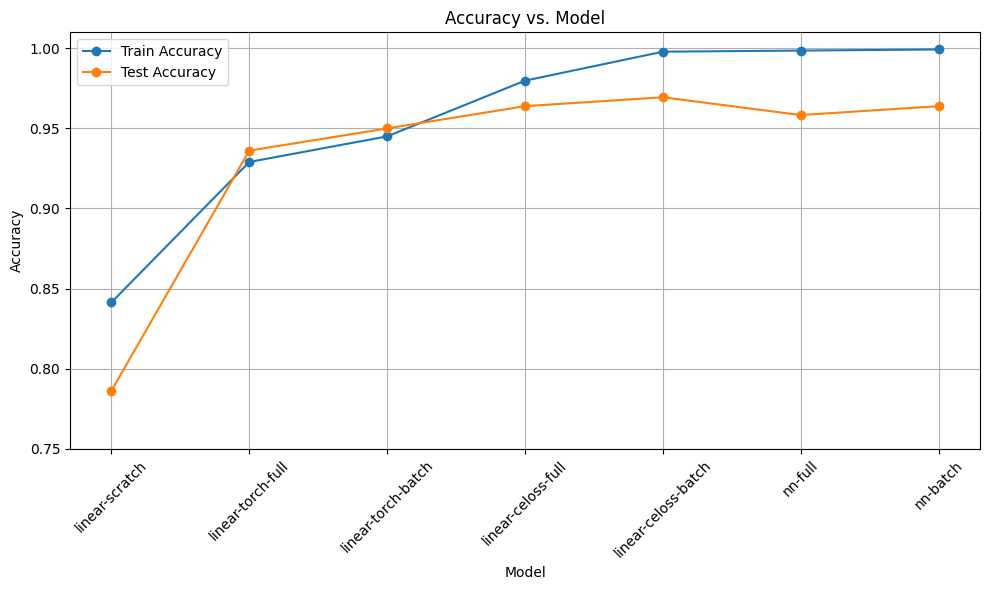

In [2]:
import matplotlib.pyplot as plt

xlabels = ['linear-scratch', 'linear-torch-full', 'linear-torch-batch', 
           'linear-celoss-full', 'linear-celoss-batch', 'nn-full', 'nn-batch']
train_accuracies = [0.8413361169102297, 0.9290187891440501, 0.9450243562978428, 
                    0.9798190675017397, 0.9979123173277662, 0.9986082115518441, 0.9993041057759221]
test_accuracies = [0.7861111111111111, 0.9361111111111111, 0.95, 
                   0.9638888888888889, 0.9694444444444444, 0.9555555555555556, 0.9638888888888889]

plt.figure(figsize=(10, 6))
plt.plot(xlabels, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(xlabels, test_accuracies, marker='o', label='Test Accuracy')

plt.xticks(rotation=45)
plt.ylim(0.75, 1.01)
plt.title('Accuracy vs. Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### #1.Analysis

 (Four Questions)
 
**# Effect of using full vs. batch gradient descent:**

**Effect:** Mini-batch gradient descent helps mitigate overfitting and generally leads to better generalization performance.

**Experimental Evidence:** Comparisons between (2 vs 3), (4 vs 5), and (6 vs 7) show that, after applying mini-batch gradient descent:

- Both MSE and Cross-Entropy (CE) losses exhibit a clear performance gain in linear models—likely due to improved generalization.
- For neural networks (NN), the improvements are less significant.

**Possible Reasons:**

- Full-batch gradient descent calculates exact gradients based on the entire dataset, which provides a stable update direction but may get stuck in local optima and is more prone to overfitting. (Both linear model settings using full batch showed signs of overfitting.)

- Mini-batch gradient descent uses small random subsets of data to approximate the gradient, resulting in more frequent updates. The noise introduced by the approximation can help models escape local minima and improve generalization. It may also accelerate convergence in practice.


**# Effect of using different loss strategy:**

**Effect:** Cross-Entropy loss is more suitable for classification tasks and tends to result in better test accuracy.

**Experimental Evidence:**

- (2 vs 4) Full-batch Linear Model: CE outperforms MSE

- (3 vs 5) Mini-batch Linear Model: CE also outperforms MSE

**Possible Reasons:**

- Cross-Entropy measures the KL divergence between predicted and true label distributions, making it more effective for classification tasks.

- In contrast, Mean Squared Error (MSE) simply measures L2 distance between two vectors. When applied to one-hot encoded labels, it penalizes all output dimensions, even when the prediction is very close to the correct class, leading to suboptimal loss signals.


**# Effect of using linear vs. non-linear models:**

**Effect:** Neural networks (non-linear model) are generally better at capturing nonlinear patterns and tend to outperform linear models on high-dimensional or complex data. However, in this experiment, the performance gain is limited (MNIST is a relatively easy task).

**Experimental Evidence:**
- (4 vs 6), (5 vs 7) comparisons show that both linear models and neural networks achieve similar performance on the MNIST classification task.

**Possible Reasons:** MNIST is relatively simple and highly linearly separable. As a result, linear models already achieve strong performance, and the added nonlinearity of neural networks offers little benefit in this case. This suggests the task does not demand complex feature representations.


**# Training time per epoch in different cases:**

**Observation:**

- SGD-based training typically takes longer than GD
- Training linear models tends to take longer than training NNs
- There is no significant time difference between using CE and MSE

**Possible Reasons:**

- SGD vs GD -> (2 vs 3), (4 vs 5), (6 vs 7): Although SGD introduces noisy updates, it helps models avoid getting trapped in local minima and results in more stable training. Due to its faster early descent (as seen in training curves), it often triggers early stopping after fewer epochs—typically about half as many as full GD. Despite faster per-step computations, the frequent updates in mini-batch training increase total update counts, often resulting in longer overall training time than GD.

- Linear vs NN -> (4 vs 6), (5 vs 7): Neural networks converge more quickly because of their stronger learning capacity, which trigger early stopping sooner than linear models.